# LSTM Classification of 6 Most Common Plastics from Fourier Transform Infrared Spectroscopy (FTIR): Technical Modelling

## Introduction

Fourier Transform Infrared Spectroscopy is a fast, inexpensive, and increasingly portable analytical tool that sees widespread use for quality assurance and environmental monitoring, as well as in many domains of research. However, information sharing and standardization across use cases is generally minimal - as it stands, most comprehensive resources for people learning to fully interpret spectra are still only available in classical print materials and digital spectra libraries are largely controlled by device manufacturers, only accessible via severely under-powered proprietary user interfaces. Deep learning interpretation in FTIR is a critically under-explored domain, especially given the sheer density of information that an FTIR spectra can capture and the machine-accessibility of the outputs. 

To create this dataset, researchers from University of Mexico have published 6000 FTIR spectra, 1000 each of 6 of the most common plastics used in consumer goods: High-Density Polyethylene (HDPE), Low-Density Polyethylene (LDPE), Polyethylene Terephthalate (PET), Polypropylene (PP), Polystyrene (PS), and Polyvinyl Chloride (PVC). For this project we will be using this data to build an LSTM to process the FTIR signal and classify it correctly. Automating this task could have considerable benefit in recycling, environmental monitoring, and quality control.

Dataset provided on Zenodo:  
[![DOI](https://zenodo.org/badge/DOI/10.52821/zenodo.10736650.svg)](https://doi.org/10.52821/zenodo.10736650)

*Instructions:* To use this notebook, you must download the above dataset, unzip it to the folder "*this-repo*/data/", unzip both resultant folders in-place (FTIR-PLASTIC-c4 and FTIR-PLASTIC-c8) and then unzip the six folders inside each of those folders in-place (HDPE, LDPE, PET, PP, PS, and PVC). The unzipped data occupies about 196MB. 


In [ ]:
# Utility and preprocessing imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [34]:
# LSTM components for sequence classification
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [35]:
# Set up some environment variables

# Our random state for splitting
rseed=1812


# These are the plastics we'll be labeling
polymers = ['HDPE','LDPE','PET','PP','PS','PVC']

In [36]:
# Time to get our full dataset loaded. 
# If this doesn't work, please go run the EDA notebook to create the appropriate files.
if os.path.exists('data/data_train.csv'):
    data_train = pd.read_csv('data/data_train.csv', index_col=False)
    data_test = pd.read_csv('data/data_test.csv', index_col=False)

In [37]:
# Assign X and y 
# One-hot the target classes 
encoder=OneHotEncoder(sparse_output=False)
y_train=encoder.fit_transform(np.array(data_train['label']).reshape(-1,1))
y_test=np.array(data_test['label']).reshape(-1,1)

# Let's invert from transmission to (something like) absorbance for a more traditional signal shape (baseline near 0, peaks near 1) to hopefully help our model out 
X_train=data_train.drop(columns=['label']).multiply(-1).add(1)
X_test=data_test.drop(columns=['label']).multiply(-1).add(1)

In [38]:
# Reshape to try to avoid any fussiness from tensorflow
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)).astype('float64')

I started with 4 LSTM layers from an RNN time series tutorial model but accuracies and training times were abysmal, so I dropped an LSTM layer and added 2 convolutional input layers and a dense connective layer first to better identify/articulate signal features before sending to LSTM to put the pieces together and infer dependencies. I chose my kernel size and strides based on the usual size window of wavenumbers given for assigning specific bond resonances to signal peaks. A smaller initial stride size did increase accuracy gain per epoch but at cost of 50% increase in training time per epoch - the current configuration seems to present an optimal complexity balance with short training times achieving very good accuracies.

In [39]:
INPUT_CONVOLUTIONAL_LAYER = Conv1D(filters= 200,
                                    kernel_size = 20,
                                    strides=10,
                                    padding='valid',
                                    activation='relu',
                                    input_shape=(X_train.shape[1], 1))
SECOND_CONVOLUTIONAL_LAYER = Conv1D(filters=50, 
                                    kernel_size=20, 
                                    strides=10, 
                                    padding='valid',
                                    activation='relu')

FIRST_RECURRENT_LAYER =    LSTM(50, return_sequences=True)
SECOND_RECURRENT_LAYER =  LSTM(50, return_sequences=True)
THIRD_RECURRENT_LAYER =   LSTM(50)


FIRST_DROPOUT_LAYER =     Dropout(0.3)
SECOND_DROPOUT_LAYER =    Dropout(0.2)
THIRD_DROPOUT_LAYER =    Dropout(0.1)
FOURTH_DROPOUT_LAYER =    Dropout(0.1)


FIRST_CONNECTIVE_LAYER = Dense(50, activation='relu')
OUTPUT_CONNECTIVE_LAYER = Dense(6,activation='softmax')

In [40]:
model = Sequential()

model.add(INPUT_CONVOLUTIONAL_LAYER)
model.add(FIRST_DROPOUT_LAYER)
model.add(SECOND_CONVOLUTIONAL_LAYER)
model.add(SECOND_DROPOUT_LAYER)
model.add(FIRST_CONNECTIVE_LAYER)
model.add(FIRST_RECURRENT_LAYER)
model.add(THIRD_DROPOUT_LAYER)
model.add(SECOND_RECURRENT_LAYER)
model.add(FOURTH_DROPOUT_LAYER)
model.add(THIRD_RECURRENT_LAYER)
model.add(OUTPUT_CONNECTIVE_LAYER)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 185, 200)          4200      
                                                                 
 dropout_4 (Dropout)         (None, 185, 200)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 17, 50)            200050    
                                                                 
 dropout_5 (Dropout)         (None, 17, 50)            0         
                                                                 
 dense_2 (Dense)             (None, 17, 50)            2550      
                                                                 
 lstm_3 (LSTM)               (None, 17, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 17, 50)           

In [41]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [42]:
# Run 10 iterations and see what happens
short_history1 = model.fit(X_train,y_train,
                    epochs=10, batch_size=32,
                    verbose=True, validation_split=0.2)

Epoch 1/10
128/128 [==============================] - 9s 39ms/step - loss: 1.0967 - accuracy: 0.5740 - val_loss: 0.5336 - val_accuracy: 0.7873
Epoch 2/10
128/128 [==============================] - 4s 30ms/step - loss: 0.3936 - accuracy: 0.8498 - val_loss: 0.2926 - val_accuracy: 0.8971
Epoch 3/10
128/128 [==============================] - 4s 30ms/step - loss: 0.2972 - accuracy: 0.8865 - val_loss: 0.2735 - val_accuracy: 0.9137
Epoch 4/10
128/128 [==============================] - 4s 30ms/step - loss: 0.2217 - accuracy: 0.9189 - val_loss: 0.2518 - val_accuracy: 0.9010
Epoch 5/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1858 - accuracy: 0.9314 - val_loss: 0.1699 - val_accuracy: 0.9324
Epoch 6/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1682 - accuracy: 0.9419 - val_loss: 0.2030 - val_accuracy: 0.9284
Epoch 7/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1263 - accuracy: 0.9569 - val_loss: 0.2140 - val_accuracy: 0.9265

97% or higher validation accuracies in under a minute! The model is performing very well. Additional training time seems to achieve stable accuracies around 99.5%. 

In [43]:
# Use Kash's Model History Vizualization Function
def plot_training_results(history):
    """
    Visualize results of the model training using `matplotlib`.

    The visualization will include charts for accuracy and loss,
    on the training and as well as validation data sets.

    INPUTS:
        history(tf.keras.callbacks.History):
            Contains data on how the model metrics changed
            over the course of training.

    OUTPUTS:
        None.
    """
    # Get accuracy for training and validation sets
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get loss for training and validation sets
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get range of epochs to produce common plotting range
    epochs_range = history.epoch

    # Instantiate plotting figure space
    plt.figure(figsize=(20, 8))

    # Create training/validation accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Create training/validation loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Render visualization
    plt.show()

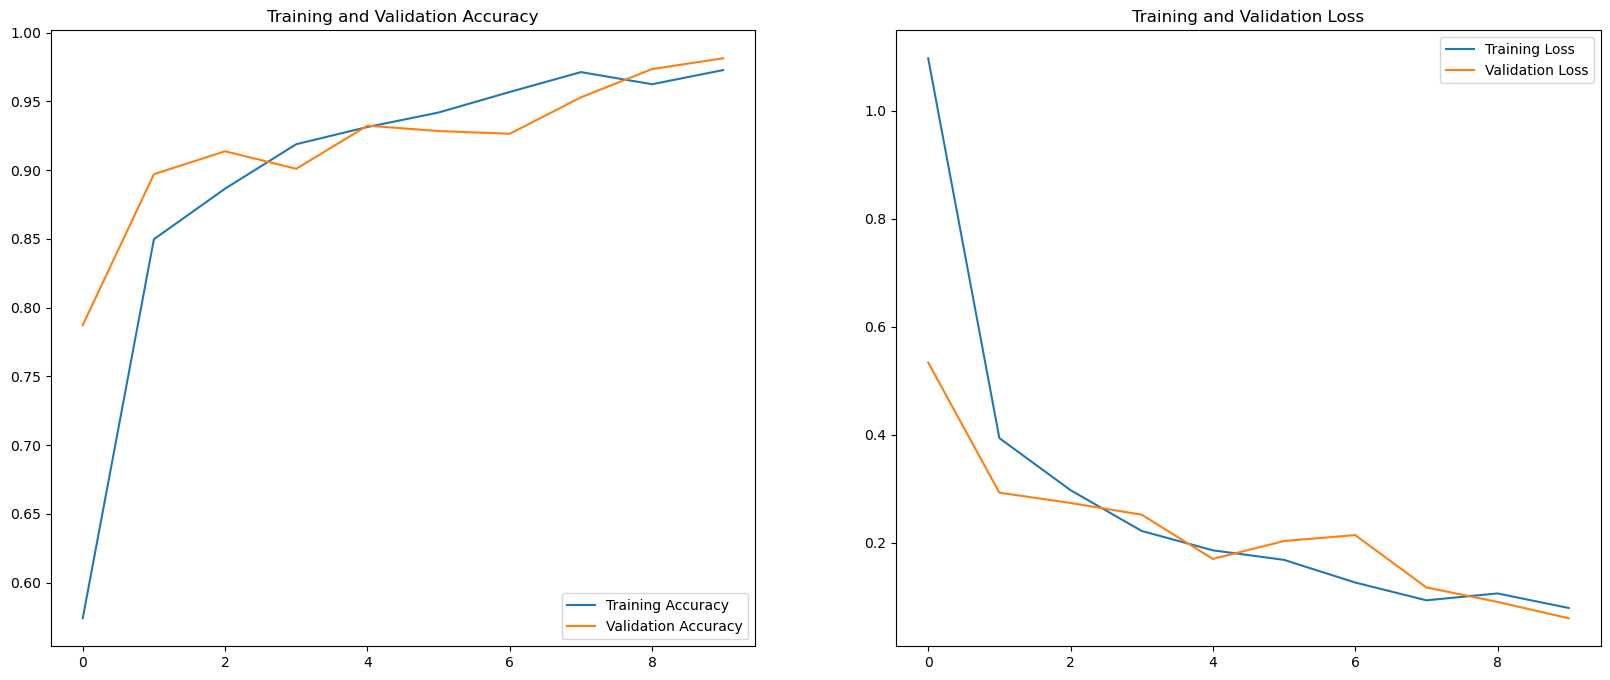

In [44]:
plot_training_results(short_history1)

Looking really nice! Seems like this model would like a little more time to fully stabilize, but I expect good things!

In [45]:
# Predict from test
y_pred = model.predict(X_test)

29/29 [==============================] - 1s 8ms/step


In [46]:
# Change one-hot back to labels to use sklearn metrics

y_pred_labeled = encoder.get_feature_names_out(y_pred)

ValueError: input_features should have length equal to number of features (1), got 900

In [ ]:
accuracy_score(y_true=y_test,y_pred=y_pred_labeled)

0.9844444444444445

In [ ]:
# borrow Kash's cmat to make my confusion matrix pretty
def cmat_(cm, labels=None):
  """ Helper function to visualize confusion matrix. """
  axis = plt.subplot()
  sns.heatmap(cm, annot=True, fmt="g", ax=axis)
  axis.set_title("Confusion Matrix")
  axis.set_xlabel("Predicted Labels")
  axis.set_ylabel("True Labels")
  if labels:
      axis.xaxis.set_ticklabels(labels)
      axis.yaxis.set_ticklabels(labels)
  plt.show()

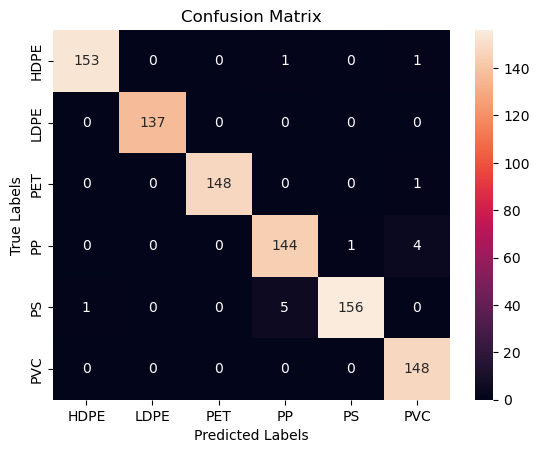

In [ ]:
cmat_(confusion_matrix(y_true=y_test_labeled,y_pred=y_pred_labeled),labels=polymers)

Really good! HDPE and LDPE are genuinely hard to distinguish - I'm surprised the model did as well as it did with them! It looks like is struggled a bit with polypropylene too. 

# Conclusion and Next Steps